<a href="https://colab.research.google.com/github/Hersheys19/ME5920-Assignment1/blob/main/ME5920_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
import einops
import os
import cv2
import random
from scipy import ndimage

# 2.1 Exploratory Analytics of the MNIST Dataset


In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
print(f"Total number of samples in train_dataset: {len(train_dataset)}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.00MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.33MB/s]


Total number of samples in train_dataset: 60000


In [3]:
subset_train_dataset = torch.utils.data.Subset(train_dataset, range(1000))

print(f"Size of the subset_train_dataset: {len(subset_train_dataset)}")

Size of the subset_train_dataset: 1000


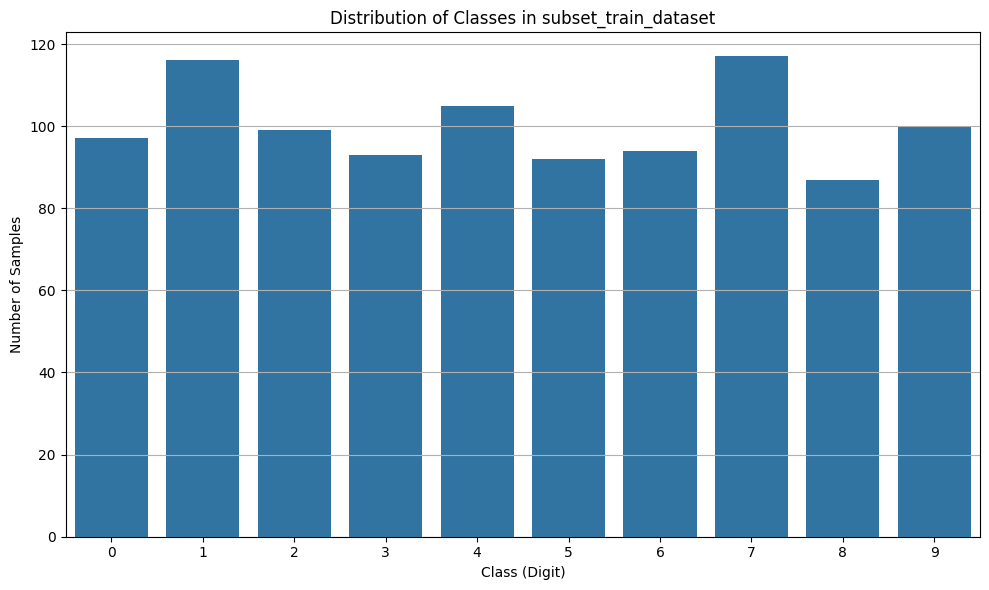

In [4]:
labels = [label for _, label in subset_train_dataset]

labels_series = pd.Series(labels)

class_counts = labels_series.value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes in subset_train_dataset')
plt.xlabel('Class (Digit)')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [5]:
all_images = torch.stack([image for image, _ in subset_train_dataset])
print(f"Shape of all_images before batching: {all_images.shape}")

batch_size = 25

batched_images = einops.rearrange(all_images, '(b k) c h w -> b k c h w', k=batch_size)

print(f"Shape of batched_images: {batched_images.shape}")

Shape of all_images before batching: torch.Size([1000, 1, 28, 28])
Shape of batched_images: torch.Size([40, 25, 1, 28, 28])


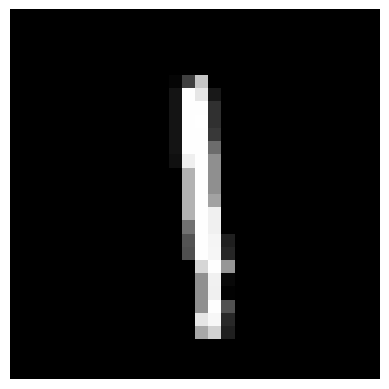

In [6]:
image, label = subset_train_dataset[8]
img = einops.rearrange(image, "c h w -> h w c")
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

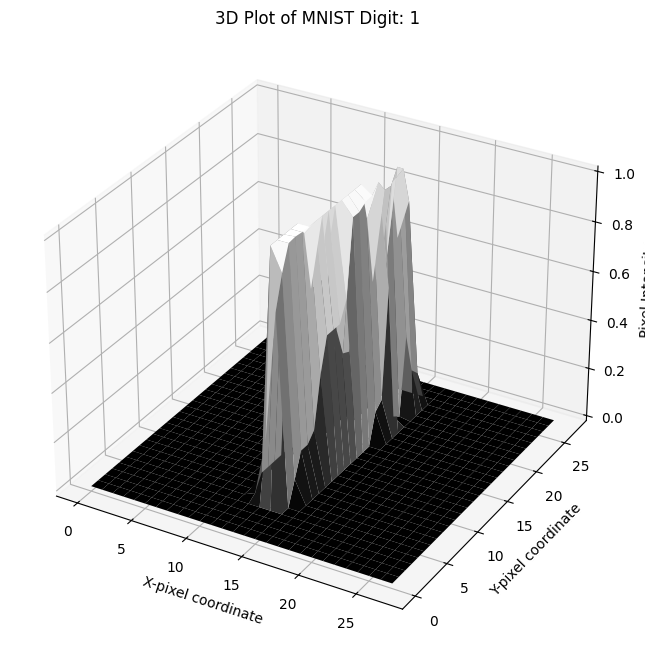

In [7]:
from mpl_toolkits.mplot3d import Axes3D

image, label = subset_train_dataset[8]

image_data = image.squeeze().numpy()

x = np.arange(0, image_data.shape[1])
y = np.arange(0, image_data.shape[0])
X, Y = np.meshgrid(x, y)

Z = image_data

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, cmap='gray')

ax.set_xlabel('X-pixel coordinate')
ax.set_ylabel('Y-pixel coordinate')
ax.set_zlabel('Pixel Intensity')
ax.set_title(f'3D Plot of MNIST Digit: {label}')

plt.show()

# 2.2 Time Series (Appliances energy over period of time)

In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

file_path = 'energydata_complete.csv'
df = pd.read_csv(file_path)

print(f"Successfully loaded data from {file_path}")
display(df.head())

Successfully loaded data from energydata_complete.csv


date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    92.0   7.000000   63.000000        5.3  13.275433  13.275433  
1    92.0   6.666667   59.166667        5.2  18.606195  18.606195  
2    92.0   6.333333   55.333333        5.1  28.642668  28.642668  
3    92.0   6.000000   51.500000        5.0  45.410389  45.410389  
4    92.0   5.666667   47.666667        4.9  10.084097  10.084097  

[5 rows x 29 columns]

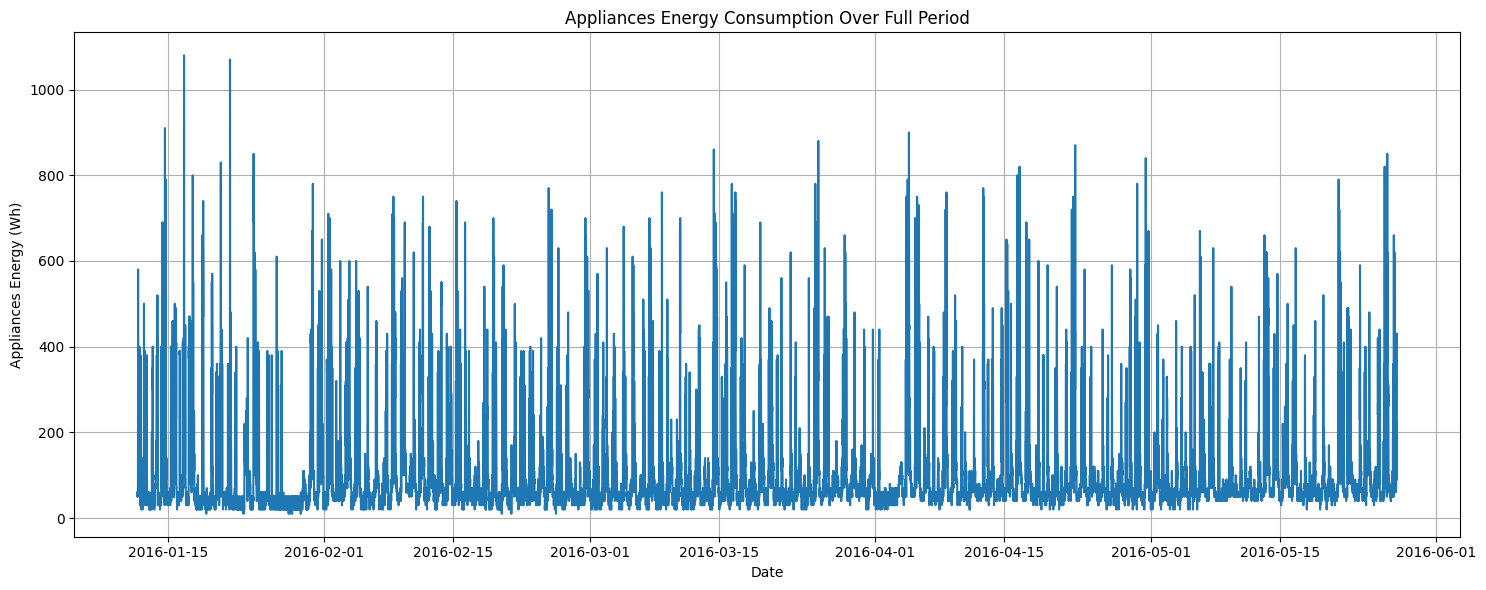

In [19]:
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='Appliances', data=df)
plt.title('Appliances Energy Consumption Over Full Period')
plt.xlabel('Date')
plt.ylabel('Appliances Energy (Wh)')
plt.grid(True)
plt.tight_layout()
plt.show()

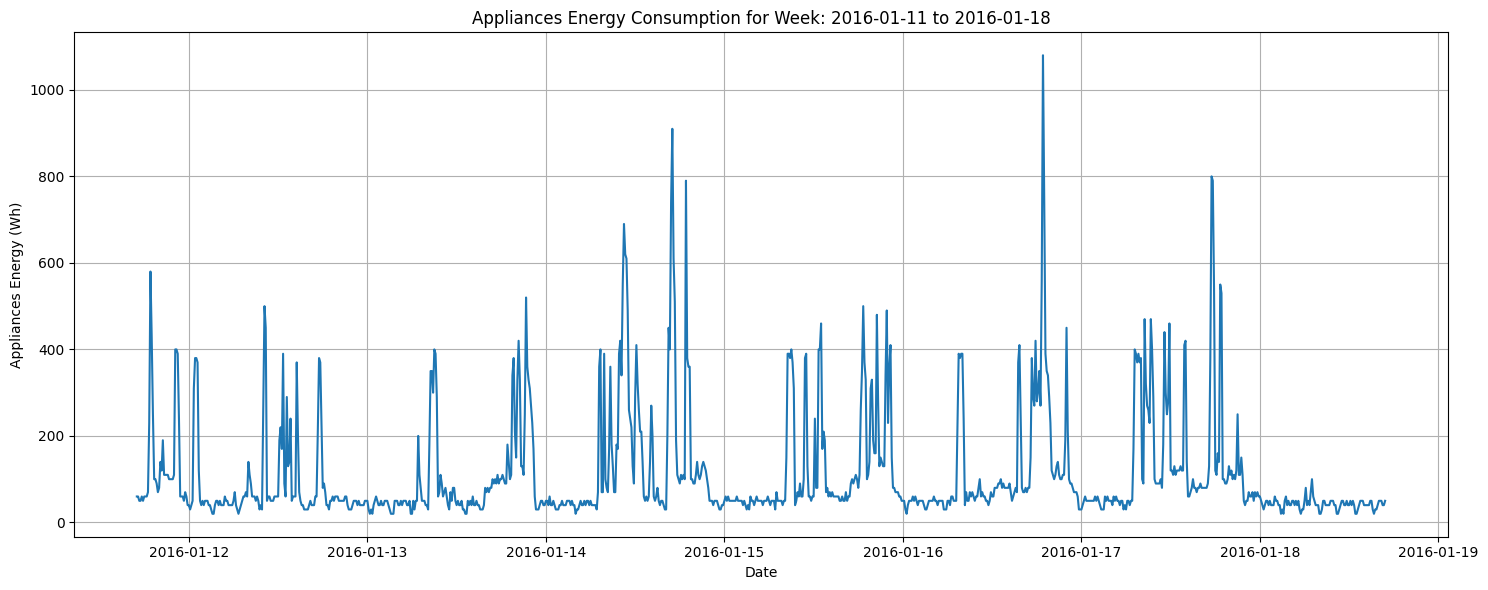

In [20]:
start_date = df['date'].min()
end_date = start_date + pd.Timedelta(weeks=1)
weekly_df = df[(df['date'] >= start_date) & (df['date'] < end_date)].copy()

plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='Appliances', data=weekly_df)
plt.title(f'Appliances Energy Consumption for Week: {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')
plt.xlabel('Date')
plt.ylabel('Appliances Energy (Wh)')
plt.grid(True)
plt.tight_layout()
plt.show()

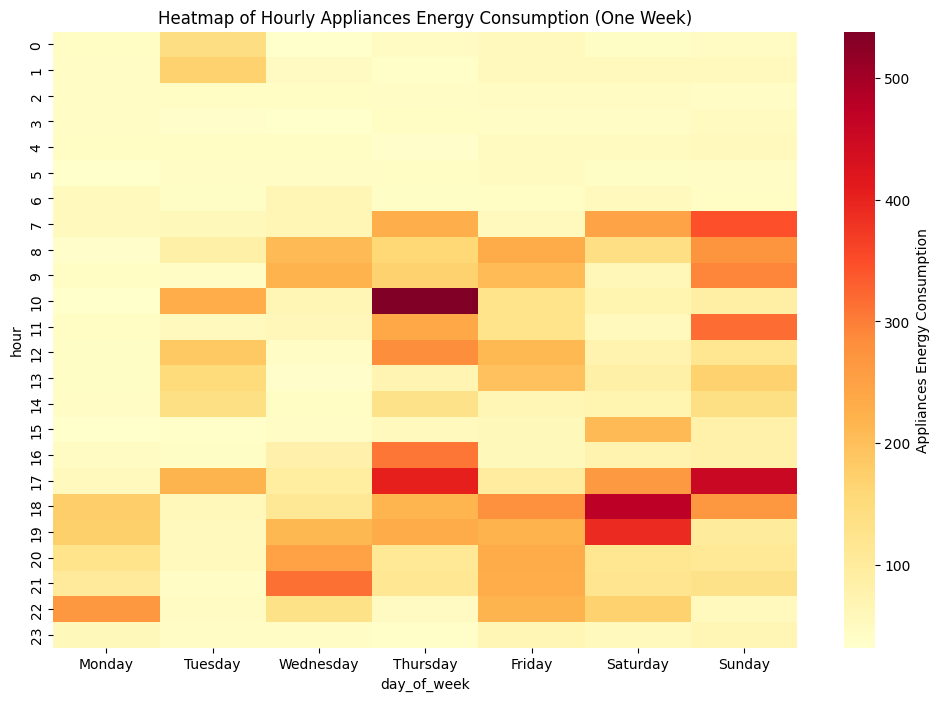

In [21]:
weekly_df['day_of_week'] = weekly_df['date'].dt.day_name()
weekly_df['hour'] = weekly_df['date'].dt.hour

heatmap_data = weekly_df.pivot_table(index='hour',
                                   columns='day_of_week',
                                   values='Appliances',
                                   aggfunc='mean')

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(columns=days_order)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, cmap='YlOrRd', cbar_kws={'label': 'Appliances Energy Consumption'})
plt.title('Heatmap of Hourly Appliances Energy Consumption (One Week)')
plt.show()

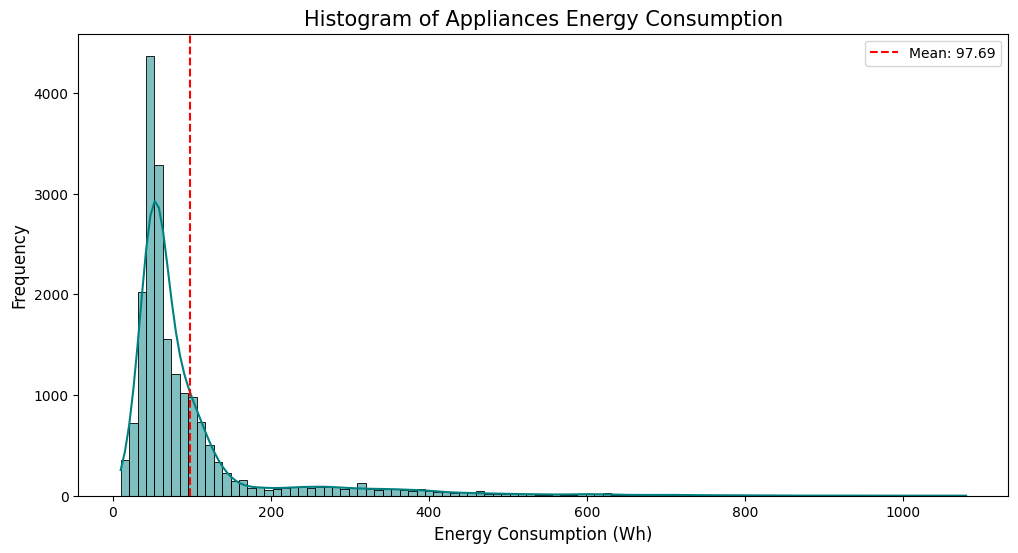

In [22]:
plt.figure(figsize=(12, 6))

sns.histplot(df['Appliances'], bins=100, kde=True, color='teal')

plt.title('Histogram of Appliances Energy Consumption', fontsize=15)
plt.xlabel('Energy Consumption (Wh)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.axvline(df['Appliances'].mean(), color='red', linestyle='--', label=f"Mean: {df['Appliances'].mean():.2f}")
plt.legend()

plt.show()

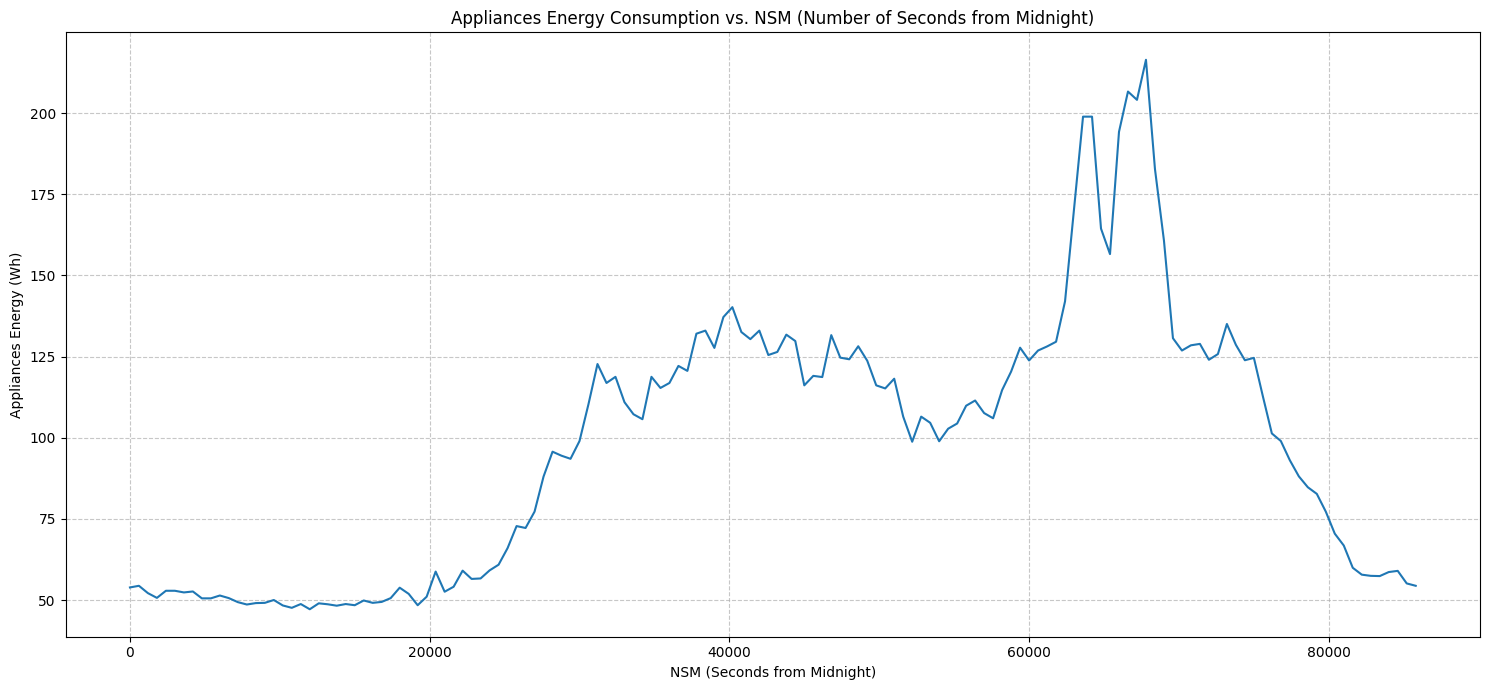

In [23]:
df['date'] = pd.to_datetime(df['date'])

df['NSM'] = df['date'].dt.hour * 3600 + \
            df['date'].dt.minute * 60 + \
            df['date'].dt.second

plt.figure(figsize=(15, 7))
sns.lineplot(x='NSM', y='Appliances', data=df, errorbar=None) # Using lineplot to see the trend, errorbar=None for cleaner look
plt.title('Appliances Energy Consumption vs. NSM (Number of Seconds from Midnight)')
plt.xlabel('NSM (Seconds from Midnight)')
plt.ylabel('Appliances Energy (Wh)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

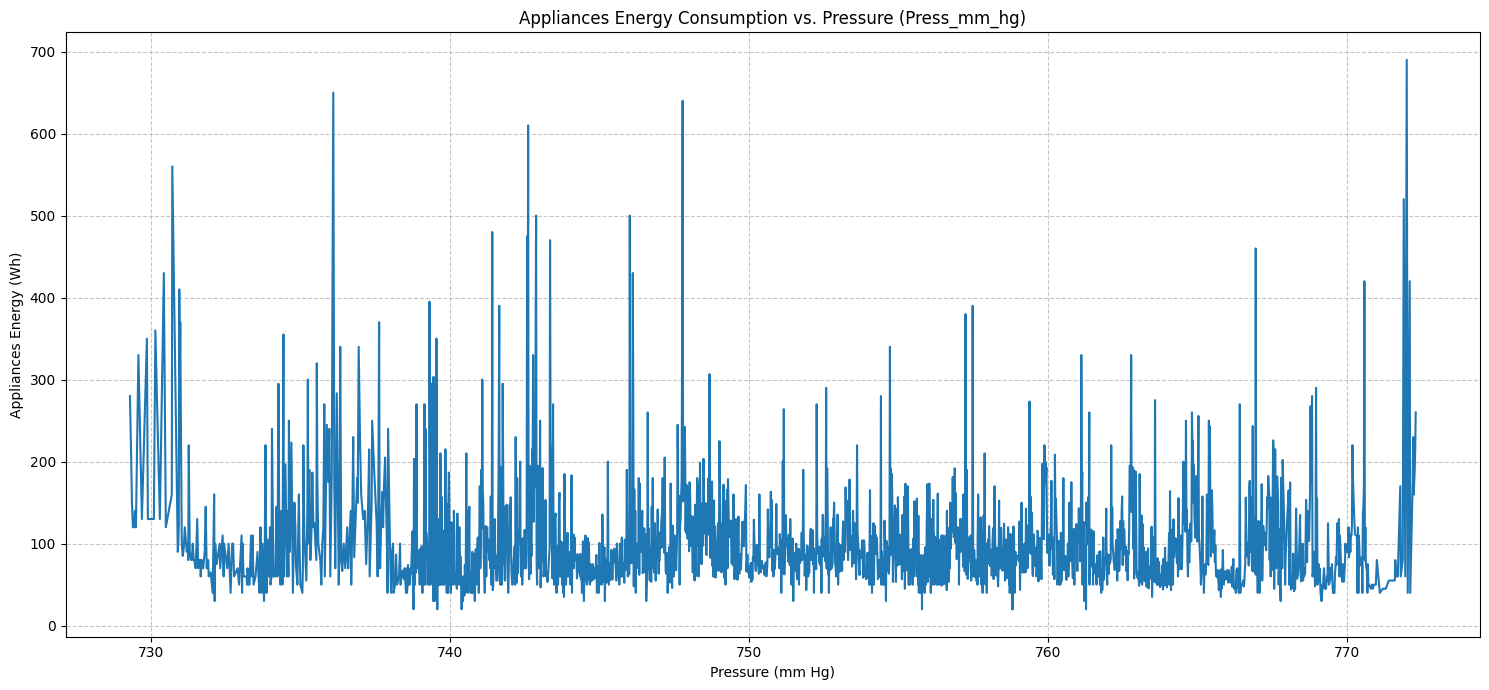

In [24]:
plt.figure(figsize=(15, 7))
sns.lineplot(x=df['Press_mm_hg'], y=df['Appliances'], data=df, errorbar=None) # Using lineplot to see the trend, errorbar=None for cleaner look
plt.title('Appliances Energy Consumption vs. Pressure (Press_mm_hg)')
plt.xlabel('Pressure (mm Hg)')
plt.ylabel('Appliances Energy (Wh)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

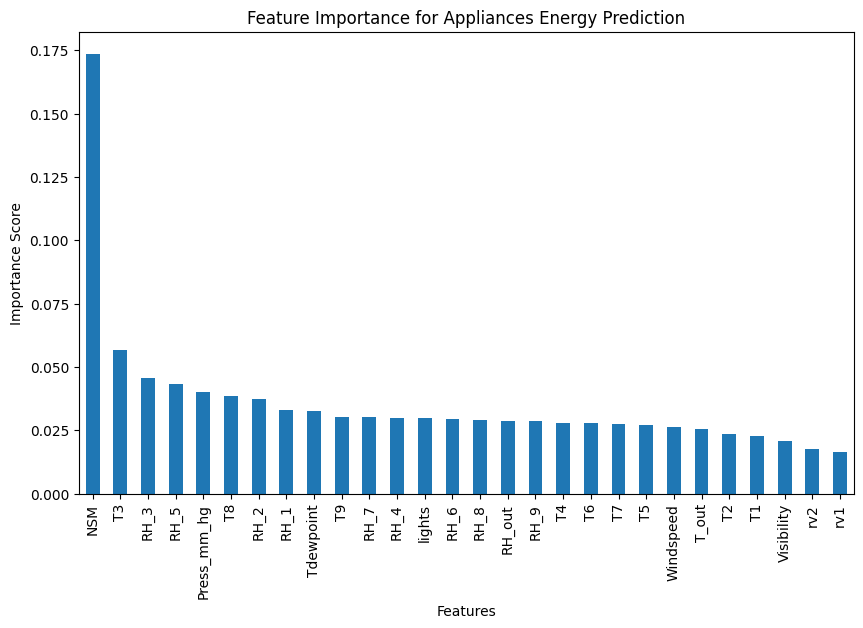

In [77]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop(columns=['Appliances', 'date']) # Removing non-predictive columns
y = df['Appliances']


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importance for Appliances Energy Prediction')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

# 2.3 Multivariate NASA Dataset

In [26]:
file_path_airfoil = 'airfoil_self_noise.dat'
df_airfoil = pd.read_csv(file_path_airfoil, delim_whitespace=True, header=None)
df_airfoil.head()

/tmp/ipython-input-3050057644.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_airfoil = pd.read_csv(file_path_airfoil, delim_whitespace=True, header=None)


0    1       2     3         4        5
0   800  0.0  0.3048  71.3  0.002663  126.201
1  1000  0.0  0.3048  71.3  0.002663  125.201
2  1250  0.0  0.3048  71.3  0.002663  125.951
3  1600  0.0  0.3048  71.3  0.002663  127.591
4  2000  0.0  0.3048  71.3  0.002663  127.461

In [81]:
print("Descriptive Statistics for airfoil noise data:")
print("\nMean:\n", df_airfoil.mean())
print("\nStandard Deviation:\n", df_airfoil.std())
print("\nMedian:\n",df_airfoil.median())
print("\nKurtosis:\n", df_airfoil.kurt())
print("\nSkewness:\n", df_airfoil.skew())
print("\nRange:\n", df_airfoil.max() - df_airfoil.min())
print("\nmean:\n",df_airfoil[2].mean())

Descriptive Statistics for airfoil noise data:

Mean:
 0    2886.380572
1       6.782302
2       0.136548
3      50.860745
4       0.011140
5     124.835943
dtype: float64

Standard Deviation:
 0    3152.573137
1       5.918128
2       0.093541
3      15.572784
4       0.013150
5       6.898657
dtype: float64

Median:
 0    1600.000000
1       5.400000
2       0.101600
3      39.600000
4       0.004957
5     125.721000
dtype: float64

Kurtosis:
 0    5.708685
1   -0.412951
2   -1.037964
3   -1.563951
4    2.218903
5   -0.314187
dtype: float64

Skewness:
 0    2.137084
1    0.689164
2    0.457457
3    0.235852
4    1.702165
5   -0.418952
dtype: float64

Range:
 0    19800.000000
1       22.200000
2        0.279400
3       39.600000
4        0.058011
5       37.607000
dtype: float64

mean:
 0.13654823685961412


# 3.1 Image Pre-processing and transformation

In [28]:
os.makedirs("Agricultural_Image_Analytics", exist_ok=True) # The exist_ok=True flag prevents an error if the folder already exists


Successfully found 8 images.


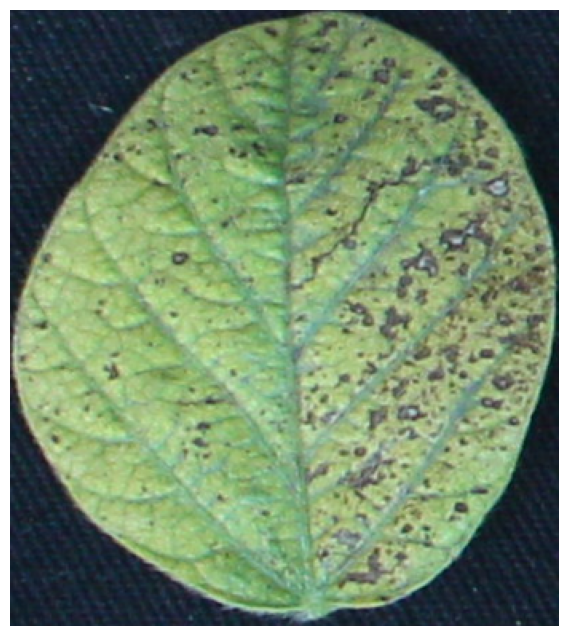

In [30]:
image_folder_path = 'Agricultural_Image_Analytics/leaves'

valid_extensions = ('.jpg', '.jpeg', '.png', '.tif', '.tiff')
image_files = sorted([
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(valid_extensions)
])
print(f"Successfully found {len(image_files)} images.")

if image_files:
    sample_img = cv2.imread(image_files[0])
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(sample_img_rgb)
    plt.axis('off')
    plt.show()

Generating 100 augmented images...
Done! 100 images saved to augmented_images


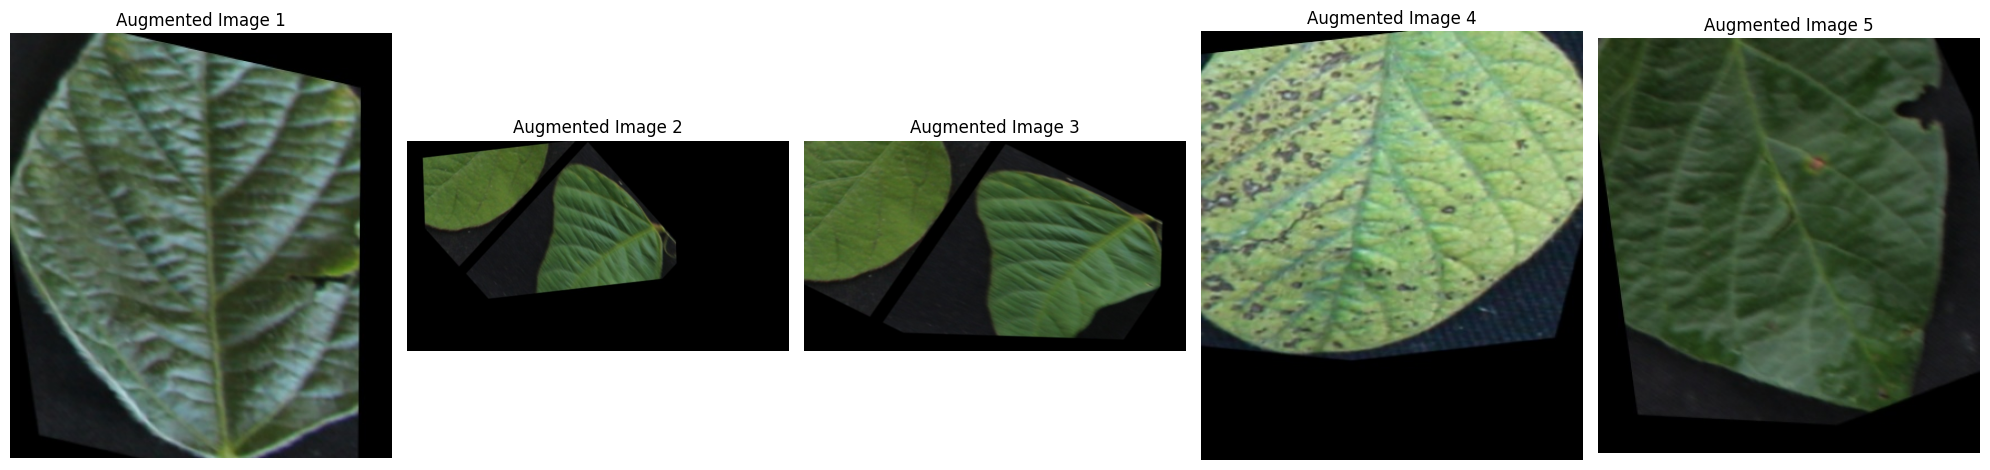

In [31]:
os.makedirs("augmented_images", exist_ok=True)
output_dir = 'augmented_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def get_random_transform(image):
    h, w = image.shape[:2]

    angle = random.uniform(-180, 180)
    M_rot = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)

    tx = random.uniform(-0.2 * w, 0.2 * w)
    ty = random.uniform(-0.2 * h, 0.2 * h)
    M_shift = np.float32([[1, 0, tx], [0, 1, ty]])

    scale = random.uniform(0.7, 1.3)
    M_scale = cv2.getRotationMatrix2D((w//2, h//2), 0, scale)

    pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
    pts2 = pts1 + np.random.uniform(-20, 20, pts1.shape).astype(np.float32)
    M_warp = cv2.getAffineTransform(pts1, pts2)

    res = cv2.warpAffine(image, M_rot, (w, h))
    res = cv2.warpAffine(res, M_shift, (w, h))
    res = cv2.warpAffine(res, M_scale, (w, h))
    res = cv2.warpAffine(res, M_warp, (w, h))

    return res


print(f"Generating 100 augmented images...")
for i in range(100):

    source_path = random.choice(image_files)
    img = cv2.imread(source_path)

    augmented_img = get_random_transform(img)

    save_path = os.path.join(output_dir, f'aug_{i+1}.jpg')
    cv2.imwrite(save_path, augmented_img)

print(f"Done! 100 images saved to {output_dir}")

aug_files = [f for f in os.listdir(output_dir) if f.endswith('.jpg')]

sample_files = random.sample(aug_files, 5)

plt.figure(figsize=(20, 10))

for i, file_name in enumerate(sample_files):
    img_path = os.path.join(output_dir, file_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"Augmented Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Extracting patches from 100 images...
Total patches extracted and saved: 500
Shape of patch array: (500, 32, 32, 3)


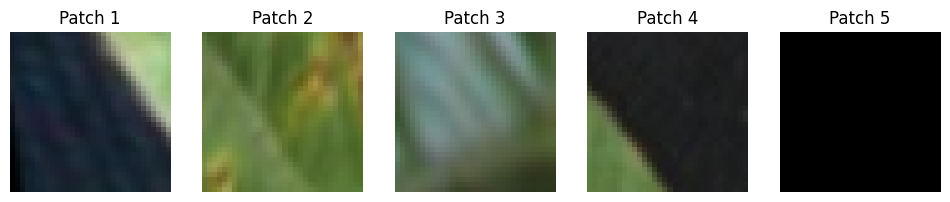

In [33]:
patch_size = 32
patches_per_image = 5
aug_dir = output_dir
os.makedirs("leaf_patches", exist_ok=True)
patch_save_dir = 'leaf_patches/'

if not os.path.exists(patch_save_dir):
    os.makedirs(patch_save_dir)

aug_files = [f for f in os.listdir(aug_dir) if f.endswith('.jpg')]
all_patches = []

print(f"Extracting patches from {len(aug_files)} images...")

patch_count = 0
for file_name in aug_files:
    img_path = os.path.join(aug_dir, file_name)
    img = cv2.imread(img_path)

    if img is None:
        continue

    h, w = img.shape[:2]

    for _ in range(patches_per_image):
        x = random.randint(0, w - patch_size)
        y = random.randint(0, h - patch_size)

        patch = img[y:y+patch_size, x:x+patch_size]
        all_patches.append(patch)


        cv2.imwrite(os.path.join(patch_save_dir, f'patch_{patch_count}.jpg'), patch)
        patch_count += 1

all_patches_arr = np.array(all_patches)

print(f"Total patches extracted and saved: {len(all_patches)}")
print(f"Shape of patch array: {all_patches_arr.shape}")

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    sample_patch = cv2.cvtColor(all_patches[random.randint(0, len(all_patches)-1)], cv2.COLOR_BGR2RGB)
    plt.imshow(sample_patch)
    plt.title(f"Patch {i+1}")
    plt.axis('off')
plt.show()

Performing ZCA whitening on patches...
Whitening complete.


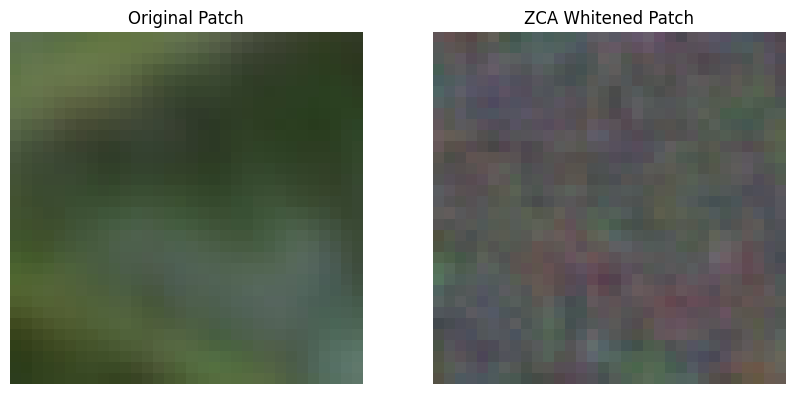

In [34]:
def zca_whitening(X, epsilon=1e-5):
    """
    Applies ZCA whitening to the data matrix X.
    X: numpy array of shape (num_samples, num_features)
    """
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    sigma = np.dot(X_centered.T, X_centered) / X_centered.shape[0]

    U, S, V = np.linalg.svd(sigma)

    zca_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T))

    X_white = np.dot(X_centered, zca_matrix)

    return X_white, X_mean

n_samples = all_patches_arr.shape[0]
X = all_patches_arr.reshape(n_samples, -1).astype('float64')

print("Performing ZCA whitening on patches...")
X_whitened_flat, X_mean = zca_whitening(X)

X_whitened = X_whitened_flat.reshape(all_patches_arr.shape)

X_whitened_vis = (X_whitened - X_whitened.min()) / (X_whitened.max() - X_whitened.min())

print("Whitening complete.")

idx = np.random.randint(0, n_samples)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(all_patches_arr[idx], cv2.COLOR_BGR2RGB))
plt.title("Original Patch")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_whitened_vis[idx])
plt.title("ZCA Whitened Patch")
plt.axis('off')

plt.show()

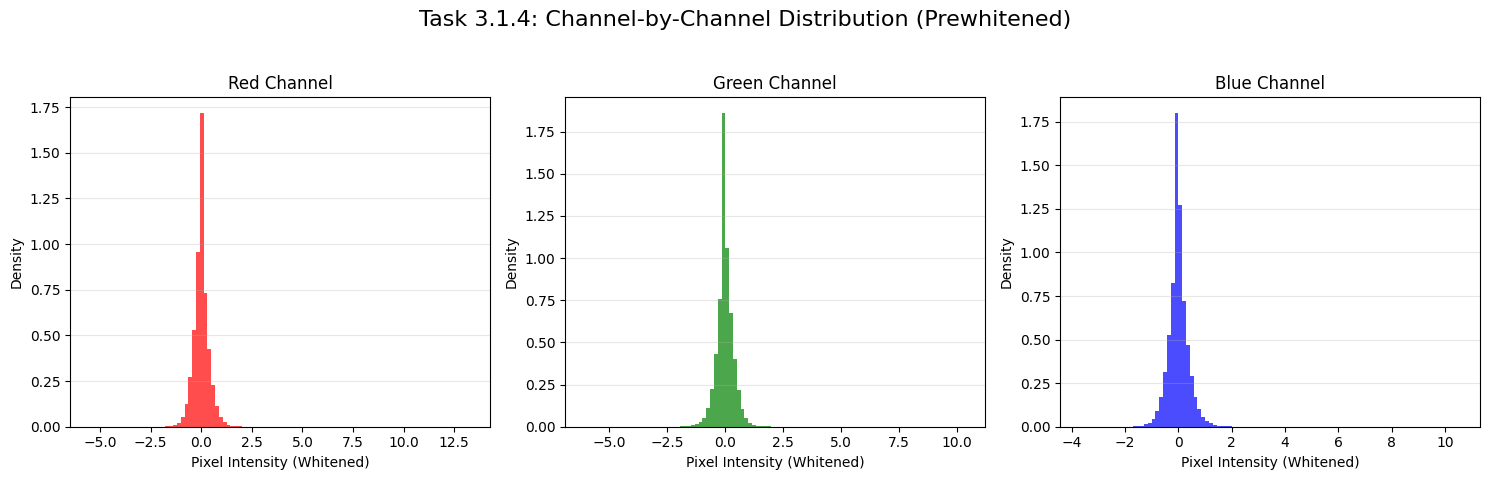

In [37]:
def plot_channel_distributions(data_array, title):
    """
    Plots the histogram for each color channel (R, G, B).
    data_array: NumPy array of shape (N, height, width, 3)
    """
    colors = ('r', 'g', 'b')
    channel_names = ('Red Channel', 'Green Channel', 'Blue Channel')

    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i, col in enumerate(colors):
        plt.subplot(1, 3, i + 1)
        channel_data = data_array[:, :, :, i].flatten()

        plt.hist(channel_data, bins=100, color=col, alpha=0.7, density=True)
        plt.title(channel_names[i])
        plt.xlabel('Pixel Intensity (Whitened)')
        plt.ylabel('Density')
        plt.grid(axis='y', alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_channel_distributions(X_whitened, "Task 3.1.4: Channel-by-Channel Distribution (Prewhitened)")

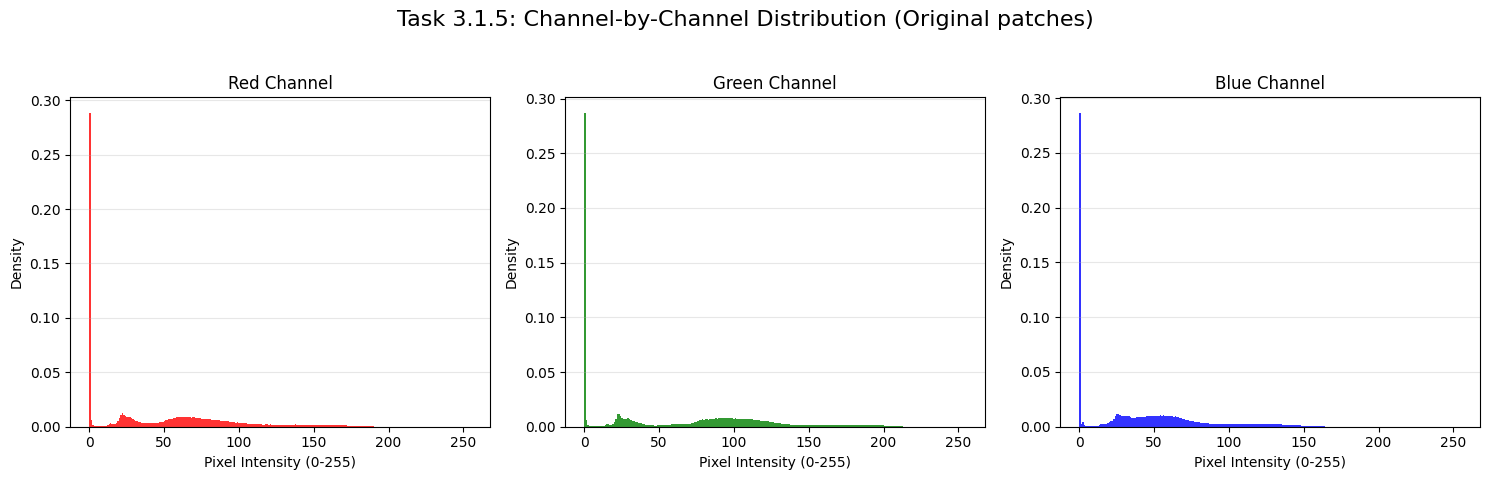

In [39]:
def plot_original_distributions(data_array, title):
    """
    Plots the histogram for each color channel (R, G, B) of the original images.
    data_array: NumPy array of shape (N, height, width, 3) in BGR format (OpenCV default).
    """
    channels = (2, 1, 0) # Index for R, G, B in a BGR image
    colors = ('r', 'g', 'b')
    names = ('Red Channel', 'Green Channel', 'Blue Channel')

    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i, (ch_idx, col) in enumerate(zip(channels, colors)):
        plt.subplot(1, 3, i + 1)

        channel_data = data_array[:, :, :, ch_idx].flatten()

        plt.hist(channel_data, bins=256, range=(0, 255), color=col, alpha=0.8, density=True)
        plt.title(names[i])
        plt.xlabel('Pixel Intensity (0-255)')
        plt.ylabel('Density')
        plt.grid(axis='y', alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_original_distributions(all_patches_arr, "Task 3.1.5: Channel-by-Channel Distribution (Original patches)")

Analyzing 8 original leaf images...


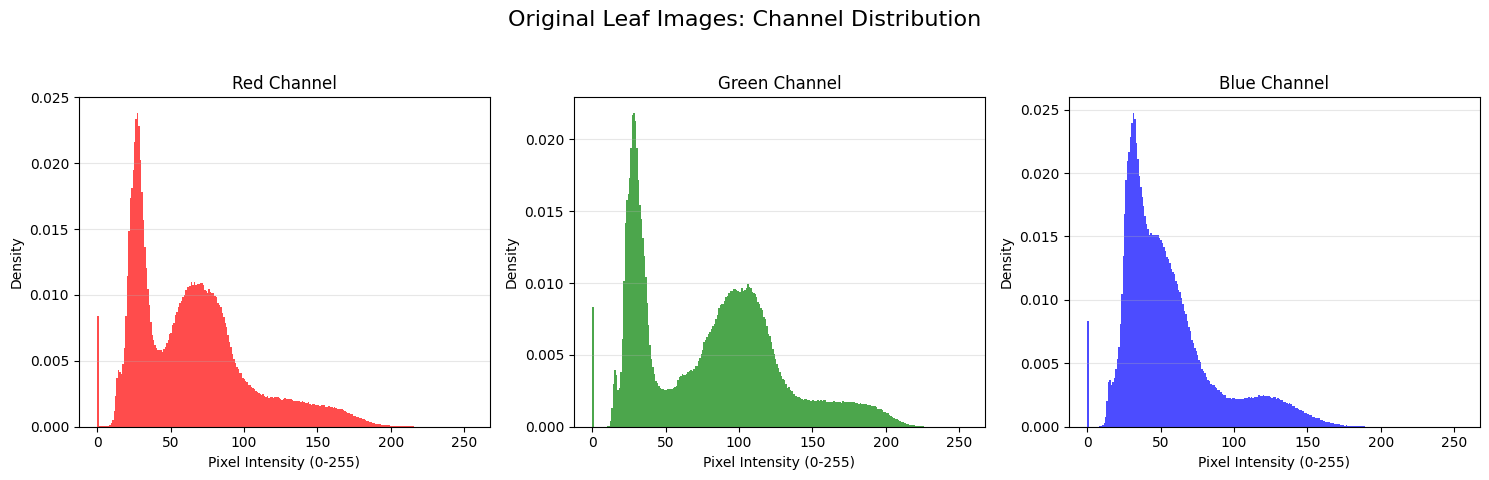

In [42]:
def plot_leaf_distributions(image_paths, title):
    red_pixels = []
    green_pixels = []
    blue_pixels = []

    print(f"Analyzing {len(image_paths)} original leaf images...")

    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        red_pixels.extend(img_rgb[:, :, 0].flatten())
        green_pixels.extend(img_rgb[:, :, 1].flatten())
        blue_pixels.extend(img_rgb[:, :, 2].flatten())

    colors = ('r', 'g', 'b')
    channel_data = [red_pixels, green_pixels, blue_pixels]
    channel_names = ('Red Channel', 'Green Channel', 'Blue Channel')

    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i, col in enumerate(colors):
        plt.subplot(1, 3, i + 1)
        plt.hist(channel_data[i], bins=256, color=col, alpha=0.7, density=True, range=(0, 255))
        plt.title(channel_names[i])
        plt.xlabel('Pixel Intensity (0-255)')
        plt.ylabel('Density')
        plt.grid(axis='y', alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_leaf_distributions(image_files, "Original Leaf Images: Channel Distribution")

Analyzing 100 augmented images...


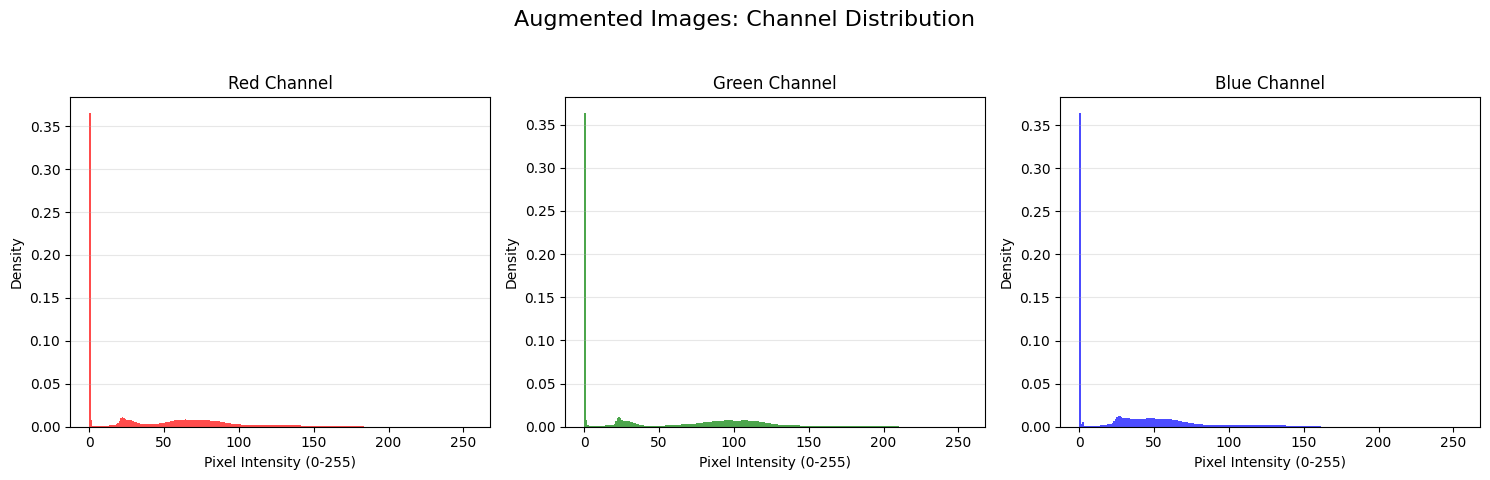

In [43]:
def plot_augmented_distribution(aug_dir_path, title):
    aug_files = [os.path.join(aug_dir_path, f) for f in os.listdir(aug_dir_path) if f.endswith('.jpg')]

    red_pixels = []
    green_pixels = []
    blue_pixels = []

    print(f"Analyzing {len(aug_files)} augmented images...")

    for path in aug_files:
        img = cv2.imread(path)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        red_pixels.extend(img_rgb[:, :, 0].flatten())
        green_pixels.extend(img_rgb[:, :, 1].flatten())
        blue_pixels.extend(img_rgb[:, :, 2].flatten())

    colors = ('r', 'g', 'b')
    channel_data = [red_pixels, green_pixels, blue_pixels]
    channel_names = ('Red Channel', 'Green Channel', 'Blue Channel')

    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i, col in enumerate(colors):
        plt.subplot(1, 3, i + 1)
        plt.hist(channel_data[i], bins=256, color=col, alpha=0.7, density=True, range=(0, 255))
        plt.title(channel_names[i])
        plt.xlabel('Pixel Intensity (0-255)')
        plt.ylabel('Density')
        plt.grid(axis='y', alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_augmented_distribution(output_dir, "Augmented Images: Channel Distribution")

# 3.2 Image Segmentation

# FINAL Code

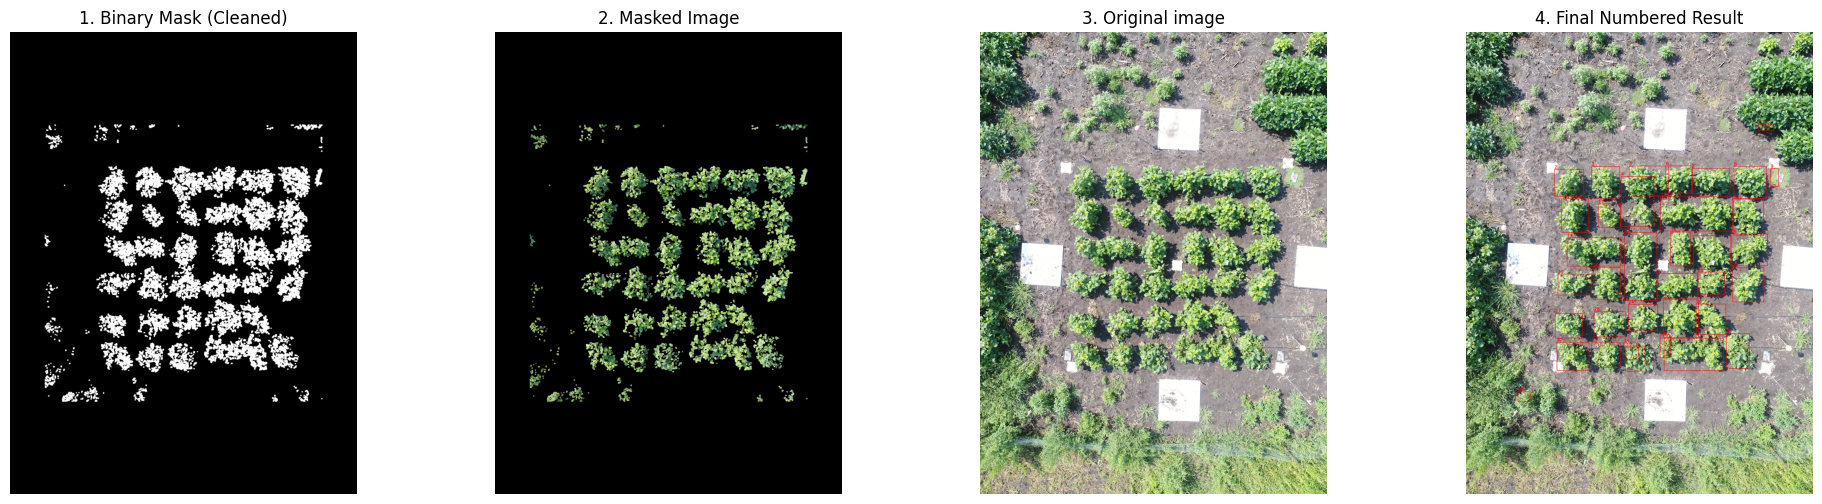

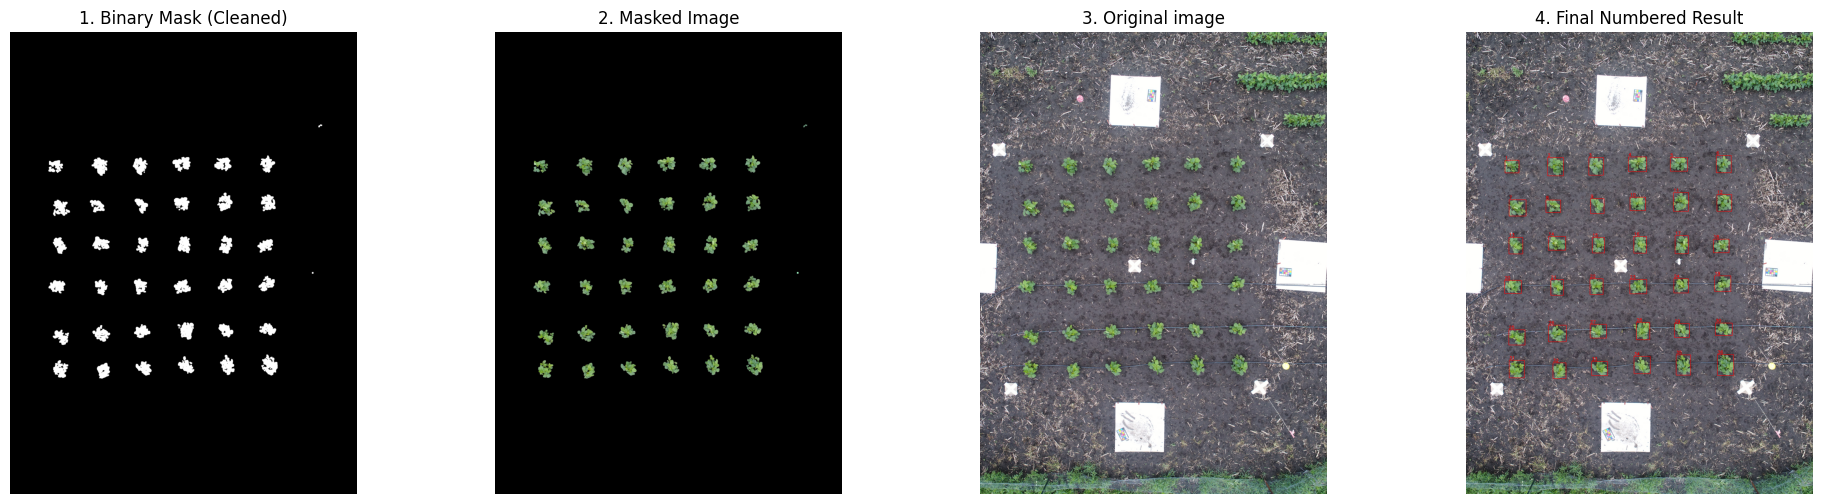

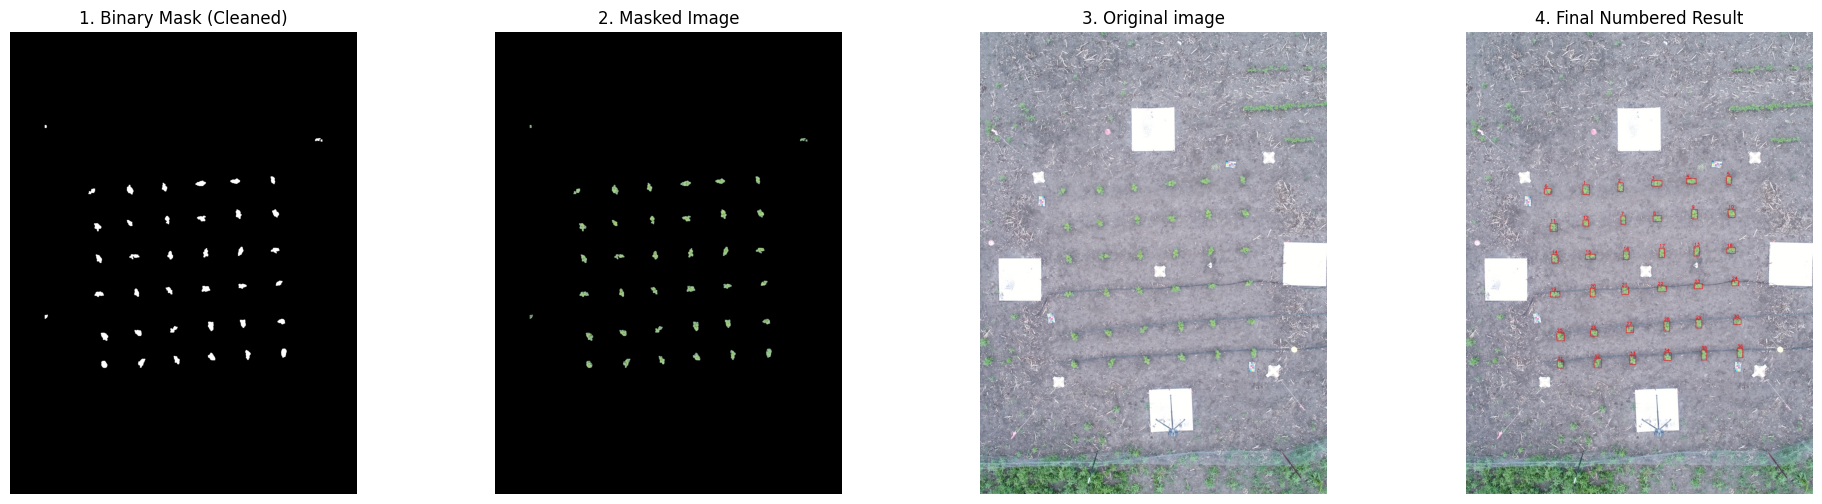

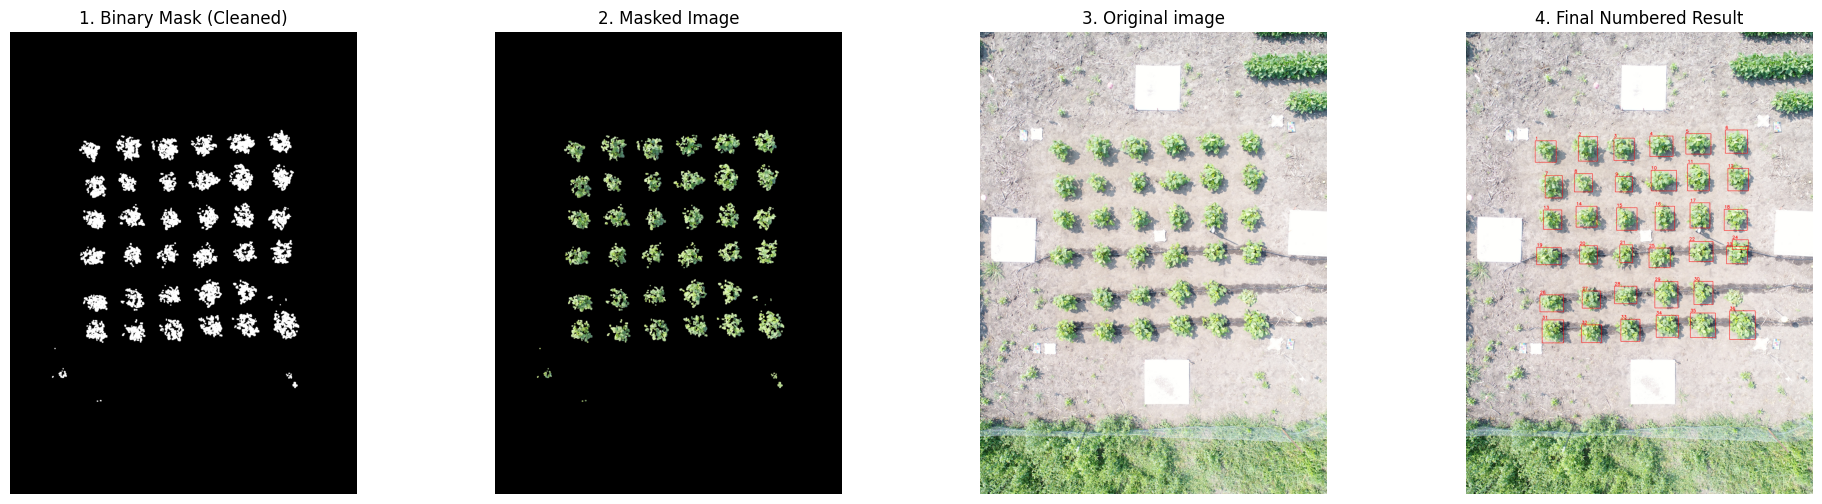

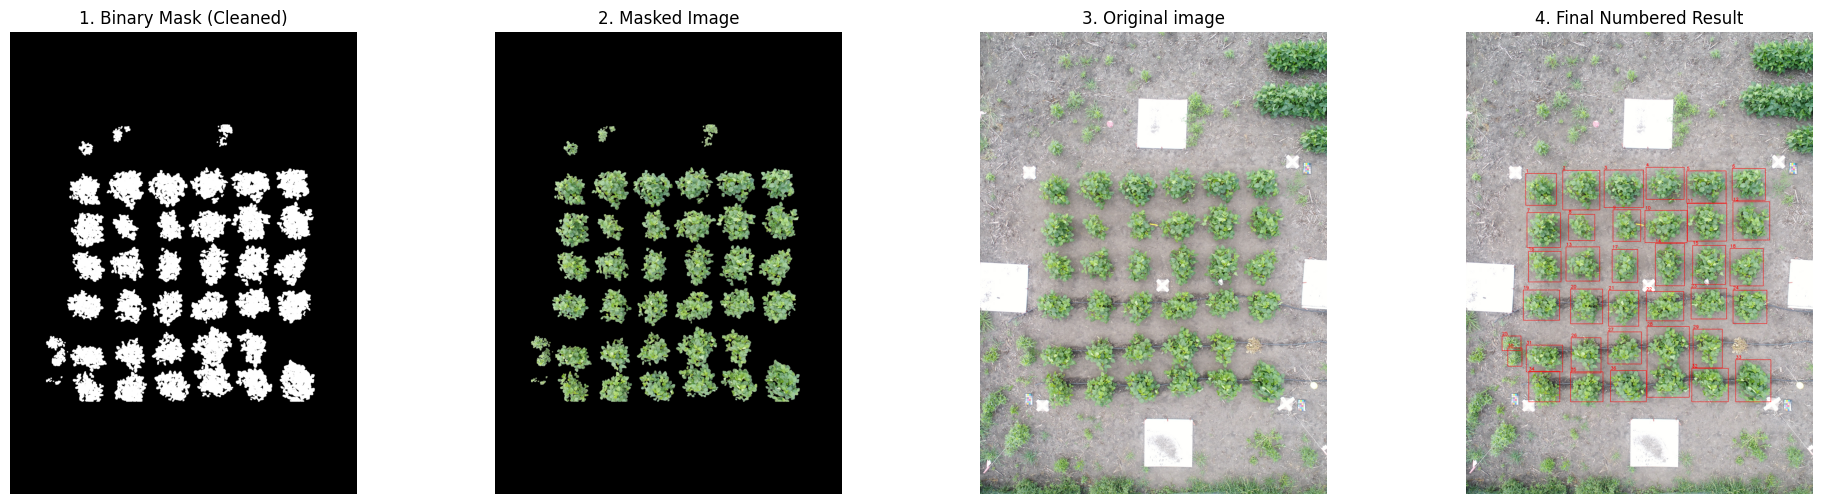

In [82]:
def fix_subplot_segmentation(input_folder, output_folder="fixed_results"):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_extensions)]
    os.makedirs(output_folder, exist_ok=True)

    for img_name in image_files:
        img = cv2.imread(os.path.join(input_folder, img_name))
        if img is None: continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lower_green = np.array([35, 40, 40])
        upper_green = np.array([90, 255, 255])
        mask = cv2.inRange(hsv, lower_green, upper_green)
        h, w = mask.shape
        mx, my = int(w * 0.10), int(h * 0.20)
        mask_roi = np.zeros_like(mask)
        mask_roi[my:h-my, mx:w-mx] = mask[my:h-my, mx:w-mx]
        mask_cleaned = cv2.morphologyEx(mask_roi, cv2.MORPH_OPEN, np.ones((12,12), np.uint8))

        img_masked = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_cleaned)

        contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img_detection = img_rgb.copy()
        candidates = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > 1500:
                x, y, w, h = cv2.boundingRect(cnt)
                candidates.append((x, y, w, h, area))

        candidates = sorted(candidates, key=lambda x: x[4], reverse=True)[:36]

        row_buffer = img.shape[0] // 15
        candidates.sort(key=lambda b: (b[1] // row_buffer, b[0]))

        img_final = img_rgb.copy()
        for i, (x, y, w, h, area) in enumerate(candidates):
            cv2.rectangle(img_final, (x, y), (x + w, y + h), (255, 0, 0), 4)
            cv2.putText(img_final, str(i+1), (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 4)

        fig, axs = plt.subplots(1, 4, figsize=(24, 6))
        axs[0].imshow(mask_cleaned, cmap='gray'); axs[0].set_title("1. Binary Mask (Cleaned)")
        axs[1].imshow(img_masked); axs[1].set_title("2. Masked Image")
        axs[2].imshow(img_detection); axs[2].set_title("3. Original image") # Before labels
        axs[3].imshow(img_final); axs[3].set_title("4. Final Numbered Result")
        for ax in axs: ax.axis('off')
        plt.show()

        cv2.imwrite(os.path.join(output_folder, img_name), cv2.cvtColor(img_final, cv2.COLOR_RGB2BGR))

fix_subplot_segmentation('Agricultural_Image_Analytics')

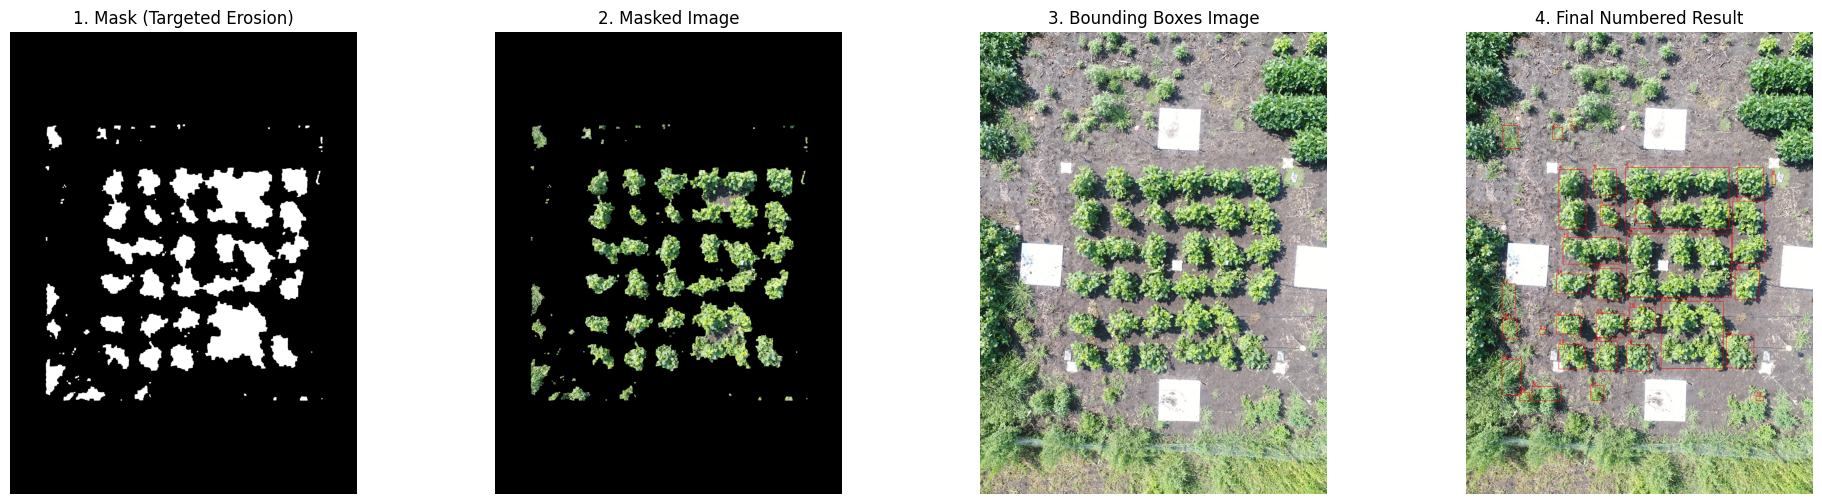

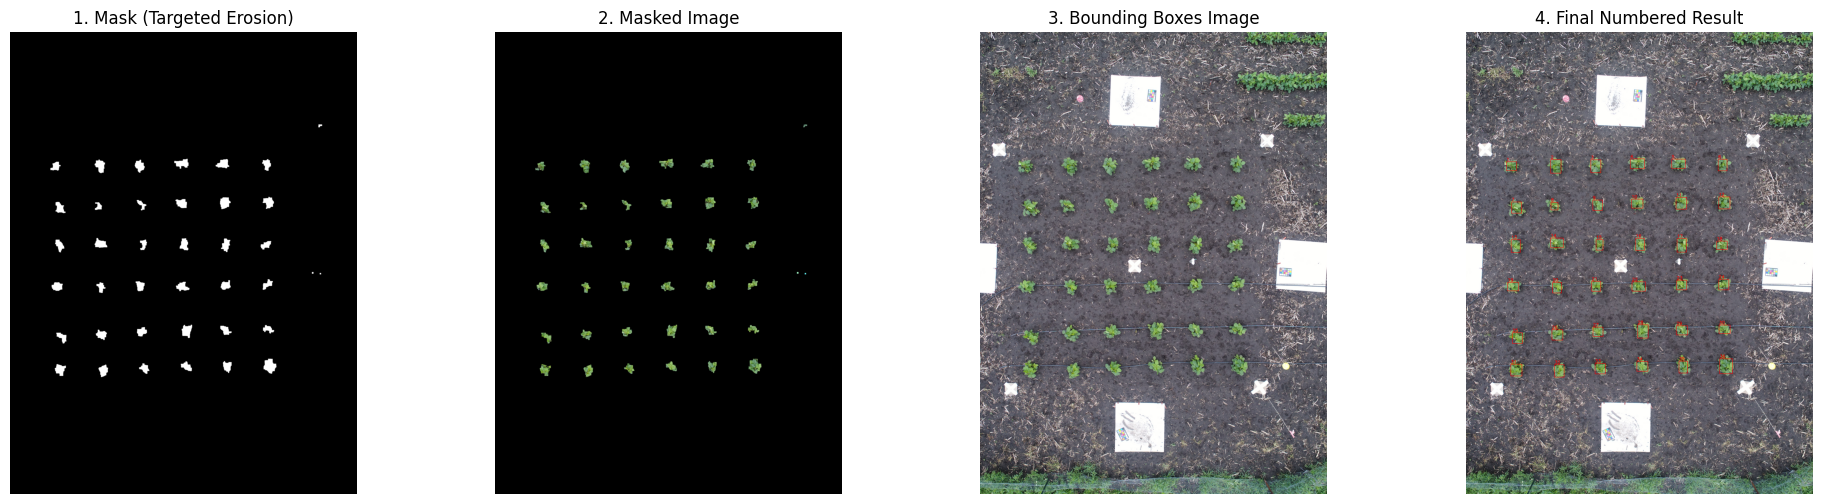

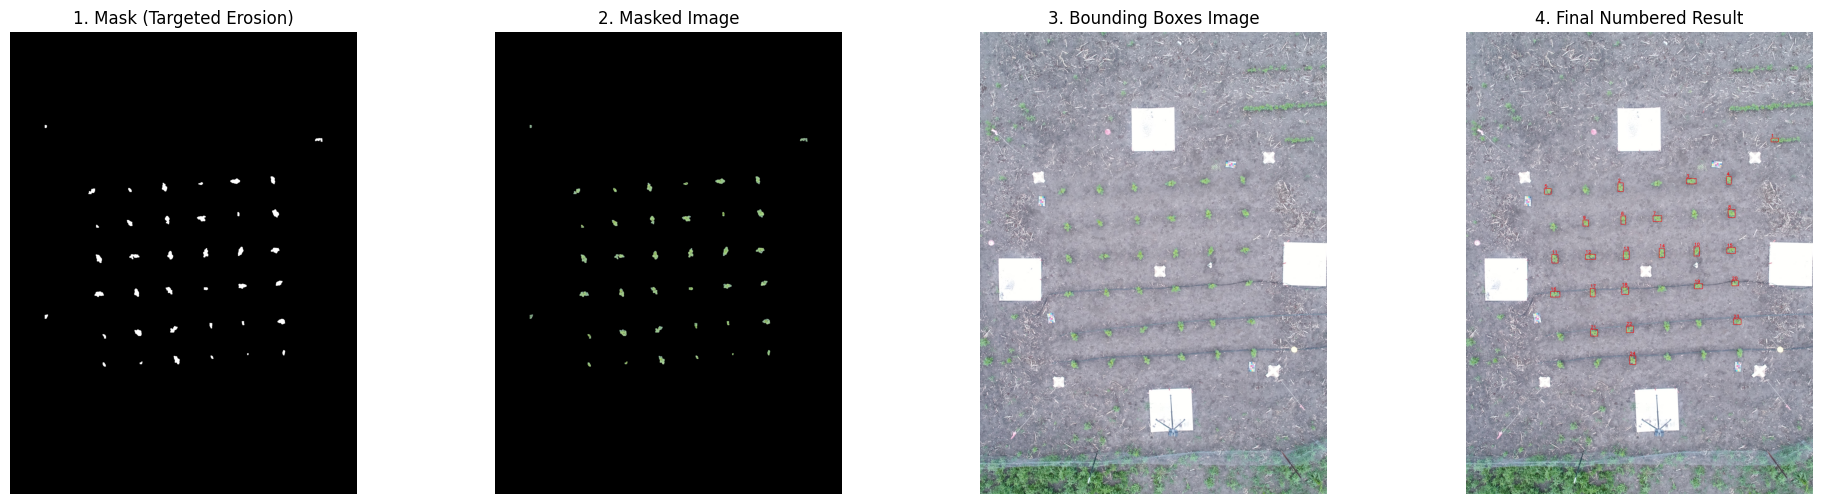

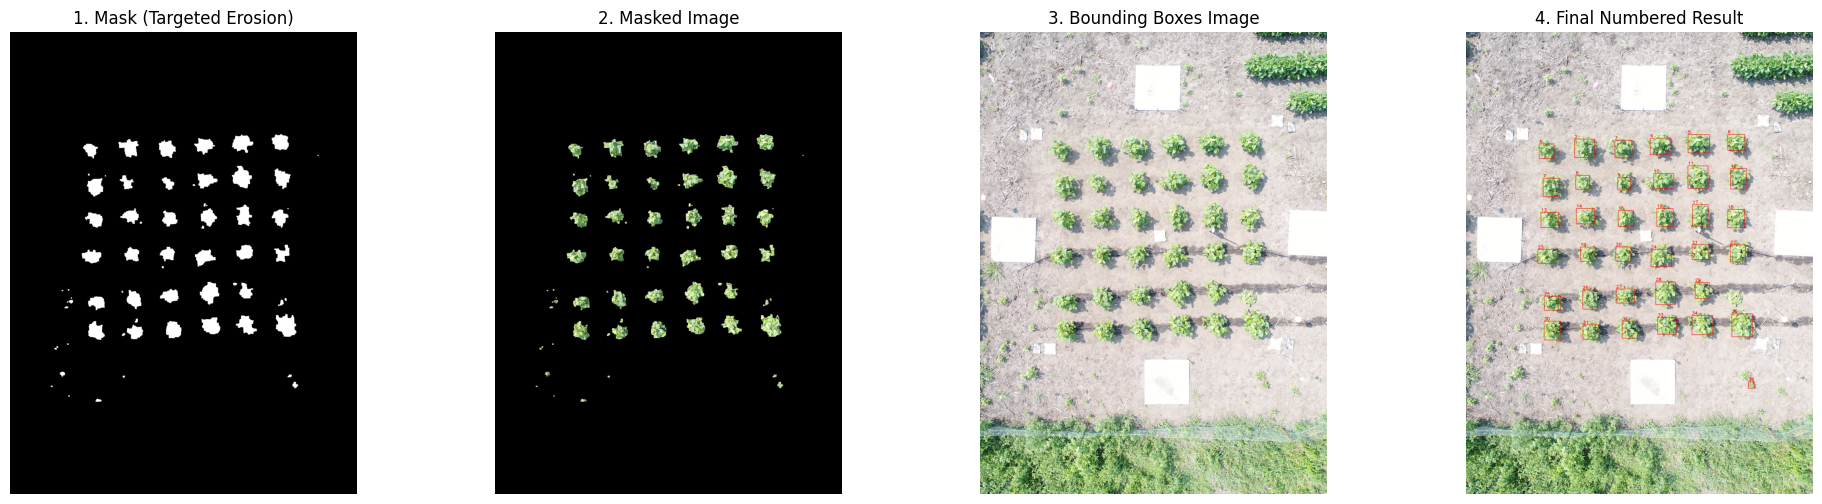

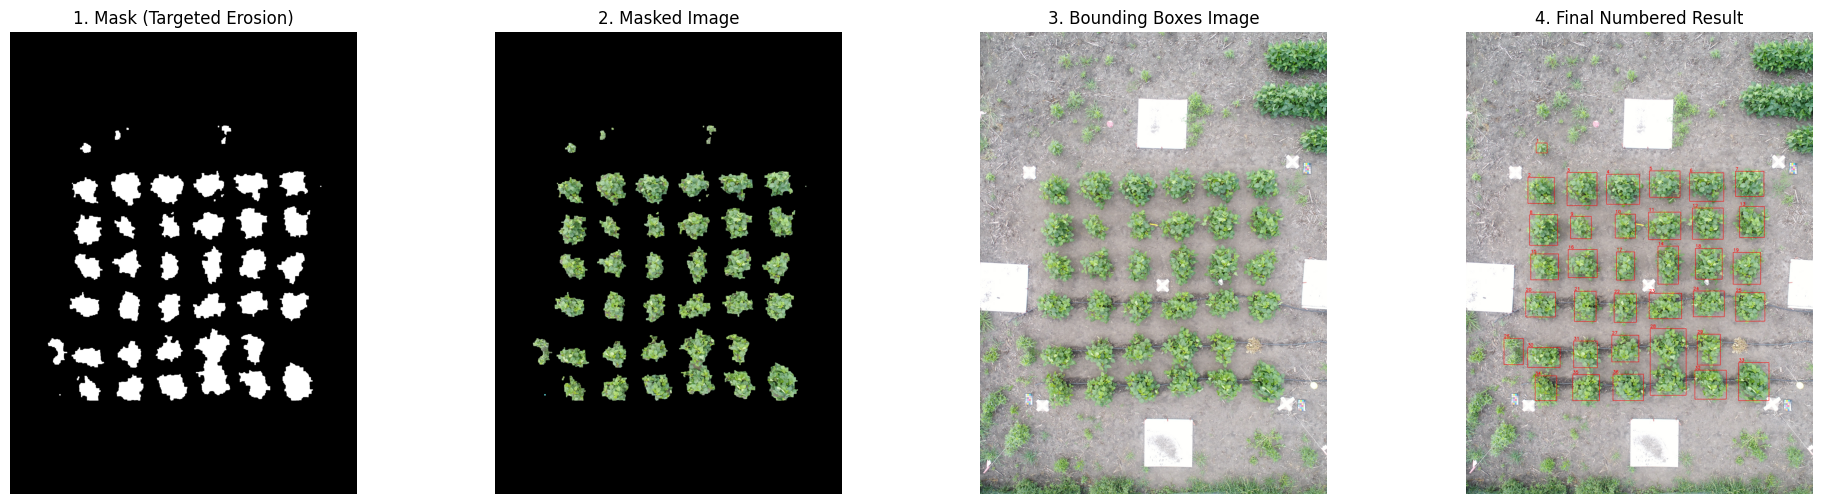

In [74]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def fix_subplot_segmentation(input_folder, output_folder="fixed_results"):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_extensions)]
    os.makedirs(output_folder, exist_ok=True)

    for img_name in image_files:
        img = cv2.imread(os.path.join(input_folder, img_name))
        if img is None: continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lower_green = np.array([35, 40, 40])
        upper_green = np.array([90, 255, 255])
        mask = cv2.inRange(hsv, lower_green, upper_green)
        h, w = mask.shape
        mx, my = int(w * 0.10), int(h * 0.20)
        mask_roi = np.zeros_like(mask)
        mask_roi[my:h-my, mx:w-mx] = mask[my:h-my, mx:w-mx]

        temp_contours, _ = cv2.findContours(mask_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_refined = np.zeros_like(mask_roi)
        kernel_erode = np.ones((7,7), np.uint8)

        for cnt in temp_contours:
            area = cv2.contourArea(cnt)
            single_contour_mask = np.zeros_like(mask_roi)
            cv2.drawContours(single_contour_mask, [cnt], -1, 255, -1)

            if area > 4000:
                eroded_blob = cv2.erode(single_contour_mask, kernel_erode, iterations=4)
                mask_refined = cv2.bitwise_or(mask_refined, eroded_blob)
            else:

                mask_refined = cv2.bitwise_or(mask_refined, single_contour_mask)


        mask_cleaned = cv2.morphologyEx(mask_refined, cv2.MORPH_OPEN, np.ones((12,12), np.uint8))
        # -----------------------------------


        img_masked = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_cleaned)


        contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img_detection = img_rgb.copy()
        candidates = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > 1500:
                x, y, w, h = cv2.boundingRect(cnt)
                candidates.append((x, y, w, h, area))


        candidates = sorted(candidates, key=lambda x: x[4], reverse=True)[:36]


        row_buffer = img.shape[0] // 15
        candidates.sort(key=lambda b: (b[1] // row_buffer, b[0]))


        img_final = img_rgb.copy()
        for i, (x, y, w, h, area) in enumerate(candidates):
            cv2.rectangle(img_final, (x, y), (x + w, y + h), (255, 0, 0), 4)
            cv2.putText(img_final, str(i+1), (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 4)


        fig, axs = plt.subplots(1, 4, figsize=(24, 6))
        axs[0].imshow(mask_cleaned, cmap='gray'); axs[0].set_title("1. Mask (Targeted Erosion)")
        axs[1].imshow(img_masked); axs[1].set_title("2. Masked Image")
        axs[2].imshow(img_detection); axs[2].set_title("3. Bounding Boxes Image")
        axs[3].imshow(img_final); axs[3].set_title("4. Final Numbered Result")
        for ax in axs: ax.axis('off')
        plt.show()


        cv2.imwrite(os.path.join(output_folder, img_name), cv2.cvtColor(img_final, cv2.COLOR_RGB2BGR))

fix_subplot_segmentation('Agricultural_Image_Analytics')